In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from collections import defaultdict
import torch
import torch.nn as nn
import tqdm.notebook as tq
from datasets import load_dataset

from __future__ import print_function
import os 

In [2]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "output/"
print(device)

cuda


## Import Pre-Trained ClinicalBert
Learning Rates and Max_Len chosen similarly to: https://aclanthology.org/N18-1100.pdf

In [3]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", cache_dir='./model_ckpt/')
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", cache_dir='./model_ckpt/')

In [4]:
# Hyperparameters
MAX_LEN = 512 # BERT input token size
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
EPOCHS = 5
# LEARNING_RATE = 3e-05
LEARNING_RATE = 5e-05

## Data Preparation
Due to compute constraints, we only look at the ones cleaned for ICD_10 and only pick the first 5000 out of ~40k examples in training, validation, test.
We also use only the top 50 ICD-10 labels to reduce the number of classes from a couple of thousand to 50. This further pre-processsing step is analogous to the method used to create the MIMIC-III 50 dataset in https://aclanthology.org/N18-1100.pdf

In [5]:
train_path = 'data/train_10_top50.csv'
test_path = 'data/test_10_top50.csv'
val_path = 'data/val_10_top50.csv'
labels_path = 'data/icd10_codes_top50.csv'

train_10_top50 = pd.read_csv(train_path)
val_10_top50 = pd.read_csv(val_path)
test_10_top50 = pd.read_csv(test_path)

train_10_top50_shorten = pd.read_csv(train_path)[:5000]
val_10_top50_shorten = pd.read_csv(val_path)[:5000]
test_10_top50_shorten = pd.read_csv(test_path)[:5000]

train_short_path = "data/train_10_top50_short.csv"
val_short_path = "data/val_10_top50_short.csv"
test_short_path = "data/test_10_top50_short.csv"

train_10_top50_shorten.to_csv(train_short_path, index=False)
val_10_top50_shorten.to_csv(val_short_path, index=False)
test_10_top50_shorten.to_csv(test_short_path, index=False)

labels_10_top50 = pd.read_csv('data/icd10_codes_top50.csv')

In [6]:
classes = [class_ for class_ in labels_10_top50["icd_code"] if class_]
class2id = {class_: id for id, class_ in enumerate(classes)}
id2class = {id: class_ for class_, id in class2id.items()}

In [7]:
class TokenizerWrapper:
    def __init__(self, tokenizer, MAX_LEN):
        self.tokenizer = tokenizer
        self.max_length = MAX_LEN
        self.classes = [class_ for class_ in labels_10_top50["icd_code"] if class_]
        self.class2id = {class_: id for id, class_ in enumerate(classes)}
        self.id2class = {id: class_ for class_, id in class2id.items()}
        
    def multi_labels_to_ids(self, labels: list[str]) -> list[float]:
        ids = [0.0] * len(self.class2id)  # BCELoss requires float as target type
        for label in labels:
            ids[self.class2id[label]] = 1.0
        return ids
    
    def tokenize_function(self, example):
        result = self.tokenizer(
            example["text"],
            max_length = self.max_length,
            padding = 'max_length',
            truncation = True,
            return_tensors='pt'
        )
        result["label"] = torch.tensor([self.multi_labels_to_ids(eval(label)) for label in example["label"]])
        return result

In [8]:
data_files = {
        "train": train_short_path,
        "validation": val_short_path,
        "test": test_short_path,
    }

tokenizer_wrapper = TokenizerWrapper(tokenizer, MAX_LEN)
dataset = load_dataset("csv", data_files=data_files)
dataset = dataset.map(tokenizer_wrapper.tokenize_function, batched=True, num_proc=1)
dataset = dataset.with_format("torch")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4221 [00:00<?, ? examples/s]

Map:   0%|          | 0/4221 [00:00<?, ? examples/s]

In [ ]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(dataset['train'], 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(dataset['validation'], 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(dataset['test'], 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

## Fine-Tune Classifier
Training, Evaluation, and Accuracy procedures adapted from: https://github.com/dtolk/multilabel-BERT/tree/master

In [10]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", cache_dir='./model_ckpt/')
        self.dropout = torch.nn.Dropout(0.2)
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 50)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [13]:
# Learning Hyperparams

# Binary Cross-Entropy Loss
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

# Adam Optimizer with Weight Decay (Default Values) with learning rate 5e-5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)   

In [14]:
# Model training per epoch
def train_model(training_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for _, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['label'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets) # BCE loss
        losses.append(loss.item())

        # training accuracy
        _, preds = torch.max(outputs, dim=1) # batch dim 
        _, targ = torch.max(targets, dim=1)  # batch dim
        num_samples += len(targ)  # technically adding batch size
        correct_predictions += torch.sum(preds == targ)

        # backward
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [15]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()
    loop = tq.tqdm(enumerate(validation_loader), total=len(validation_loader), 
                      leave=True, colour='steelblue')
    with torch.no_grad():
        for _, data in loop:
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['label'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            _, preds = torch.max(outputs, dim=1) # batch dim 
            _, targ = torch.max(targets, dim=1)  # batch dim
            num_samples += len(targ)  # technically adding batch size
            correct_predictions += torch.sum(preds == targ)
    print(float(correct_predictions)/num_samples, np.mean(losses))
    return float(correct_predictions)/num_samples, np.mean(losses)

In [17]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc >= best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"best_model_state.bin"))
        best_accuracy = val_acc

Epoch 1/5


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1056 [00:00<?, ?it/s]

0.3193556029376925 0.2864029388169222
train_loss=0.3035, val_loss=0.2864 train_acc=0.3042, val_acc=0.3194
Epoch 2/5


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1056 [00:00<?, ?it/s]

0.2902155887230514 0.2728603464466604
train_loss=0.2798, val_loss=0.2729 train_acc=0.3048, val_acc=0.2902
Epoch 3/5


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1056 [00:00<?, ?it/s]

0.28310826818289503 0.25885181491630094
train_loss=0.2623, val_loss=0.2589 train_acc=0.3242, val_acc=0.2831
Epoch 4/5


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1056 [00:00<?, ?it/s]

0.31058990760483296 0.24659950288972168
train_loss=0.2445, val_loss=0.2466 train_acc=0.3624, val_acc=0.3106
Epoch 5/5


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1056 [00:00<?, ?it/s]

0.3411513859275053 0.24247837185182355
train_loss=0.2292, val_loss=0.2425 train_acc=0.3902, val_acc=0.3412


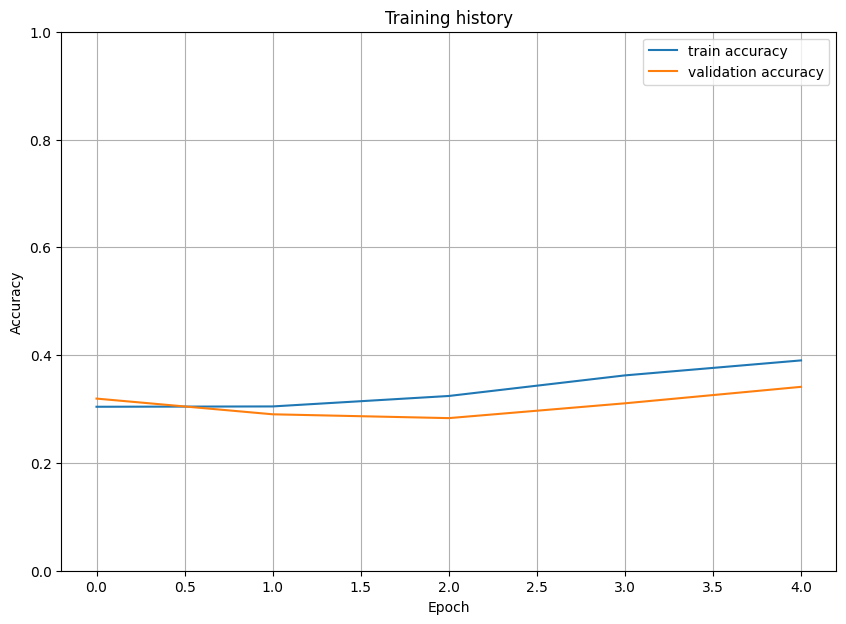

In [18]:

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

In [19]:
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(data_dir,"best_model_state.bin")))
model = model.to(device)


In [20]:
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

  0%|          | 0/1056 [00:00<?, ?it/s]

0.34896943852167733 0.24027809302435454


In [22]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["label"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()
        
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values

In [23]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [24]:
print(classification_report(target_values, predictions, target_names=labels_10_top50['icd_code'], digits=10))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       d-I10       0.81      0.68      0.74      1789
      d-E785       0.84      0.65      0.73      1670
    d-Z87891       0.48      0.19      0.27      1408
      d-K219       0.81      0.39      0.53      1102
      d-F329       0.74      0.24      0.37       705
     d-I2510       0.72      0.65      0.68       752
      d-F419       0.71      0.25      0.37       616
      d-N179       0.38      0.05      0.08       488
      d-Z794       0.51      0.45      0.48       457
      d-E039       0.86      0.47      0.60       537
     d-Z7901       0.60      0.48      0.53       476
      d-E119       0.57      0.17      0.27       532
    d-F17210       0.75      0.01      0.02       378
      d-Y929       0.00      0.00      0.00       416
     d-G4733       0.72      0.49      0.58       509
      d-E669       0.51      0.15      0.24       489
     d-I4891       0.48      0.25      0.33       433
      d-D649       0.00    

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
